# Imports

In [1]:
import matplotlib.pyplot as plt
import os
import cv2
import PIL
from tqdm import tqdm

import torch.nn.functional as F
import torch
import torch.nn as nn

import torch.autograd as autograd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.utils import make_grid, save_image

import torchvision
from torchvision import transforms, datasets

# Init

In [45]:
# Root directory for dataset
dataroot = "./celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

lambda_gp = 10.

n_critic = 5

sample_interval = 200

batches_done = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

z_test_fixed = torch.randn(64, nz, 1, 1, device=device)

# Download Dataset

In [3]:
from IPython.display import clear_output
!pip install --upgrade kaggle
clear_output()
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [4]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 98% 1.30G/1.33G [00:13<00:00, 111MB/s]
100% 1.33G/1.33G [00:14<00:00, 102MB/s]


In [6]:
!unzip -xq /content/celeba-dataset.zip -d /content/celeba

# Custom Dataset

## Human Dataset

In [35]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CelebA(Dataset):
  def __init__(self, root, transform):
    self.root = root
    self.total_imgs = os.listdir(self.root)
    self.transform = transform

  def __getitem__(self, idx):
    img = PIL.Image.open(os.path.join(self.root, self.total_imgs[idx]))
    if transform is not None:
      img = self.transform(img)

    return img

  def __len__(self):
    return len(self.total_imgs)

dataset = CelebA(root = '/content/celeba/img_align_celeba/img_align_celeba', transform = transform)

In [36]:
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, drop_last=True)

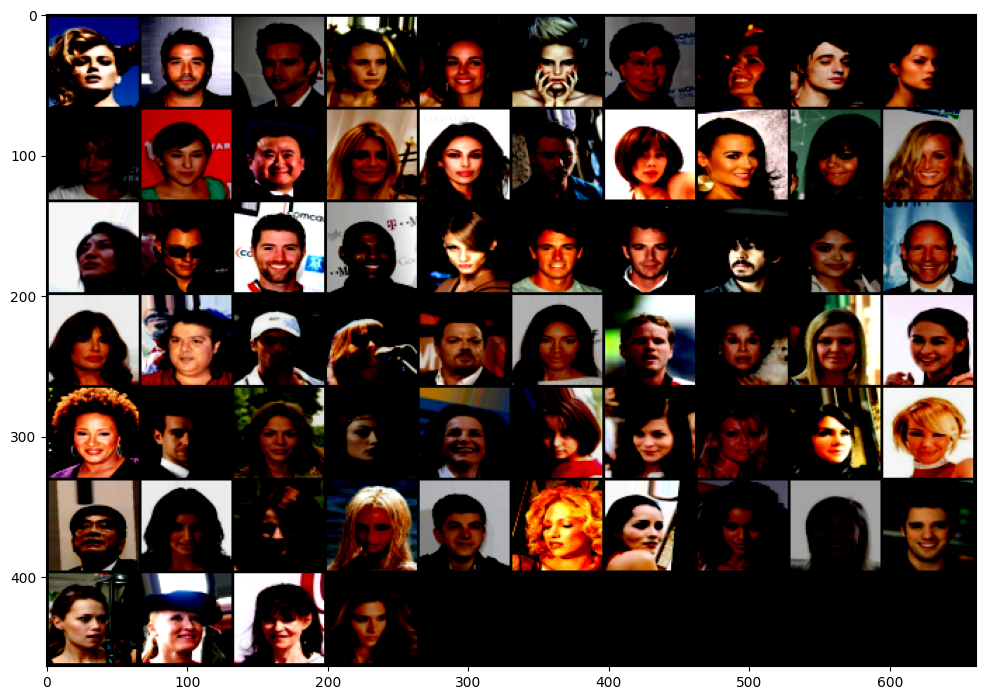

In [37]:
x = next(iter(dataloader))
img = make_grid(x, nrow=10)
plt.figure(figsize = (12, 15))
plt.imshow(img.permute(1, 2, 0))

# utils

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Generator

In [39]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
          # input is Z, going into a convolution
          nn.LazyConvTranspose2d(ngf*8, 4, 1, 0, bias=False),
          nn.LazyBatchNorm2d(eps=0.8),
          nn.ReLU(True),

          # state size. (ngf*8) x 4 x 4
          nn.LazyConvTranspose2d(ngf*4, 4, 2, 1, bias=False),
          nn.LazyBatchNorm2d(eps=0.8),
          nn.ReLU(True),

          # state size. (ngf*4) x 8 x 8
          nn.LazyConvTranspose2d(ngf*2, 4, 2, 1, bias=False),
          nn.LazyBatchNorm2d(eps=0.8),
          nn.ReLU(True),

          # state size. (ngf*2) x 16 x 16
          nn.LazyConvTranspose2d(ngf, 4, 2, 1, bias=False),
          nn.LazyBatchNorm2d(eps=0.8),
          nn.ReLU(True),

          # state size. (ngf) x 32 x 32
          nn.LazyConvTranspose2d(nc, 4, 2, 1, bias=False),
          nn.Tanh()

    # state size. (nc) x 64 x 64
)

    def forward(self, input):
        return self.main(input)

In [40]:
G = Generator(ngpu).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Discriminator

In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # ncx64x64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            nn.LazyConv2d(2*ndf, 4, 2, 1, bias=False),
            nn.LazyBatchNorm2d(eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            nn.LazyConv2d(4*ndf, 4, 2, 1, bias=False),
            nn.LazyBatchNorm2d(eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.LazyConv2d(8*ndf, 4, 2, 1, bias=False),
            nn.LazyBatchNorm2d(eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            nn.LazyConv2d(1, 4, 1, 0, bias=False),
            # nn.Sigmoid(),
            # nn.Flatten(1) ##

)

    def forward(self, input):
        return self.main(input)

In [42]:
D = Discriminator(ngpu).to(device)

# Config

In [43]:
G = Generator(ngpu).to(device)
D = Discriminator(ngpu).to(device)

optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

loss_fn = nn.BCELoss()

# My Train

In [44]:
loss_D_hist, loss_G_hist = [], []

In [46]:
def gradient_penalty_calculator(D, real_samples, fake_samples):

  alpha = torch.rand((real_samples.shape[0], 1, 1, 1), device=device)
  x_hat = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
  y_hat = D(x_hat)
  gradients = autograd.grad(outputs = y_hat,
                            inputs = x_hat,
                            grad_outputs=torch.ones_like(y_hat),
                            create_graph=True)[0]

  gradients = gradients.view(gradients.shape[0], -1)
  gradient_penalty = ((gradients.norm(2, dim = 1) - 1) ** 2).mean()

  return gradient_penalty

In [52]:
!rm -rf './Images'
os.makedirs('./Images', exist_ok=True)

for epoch in range(num_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  with tqdm(dataloader, unit="batch") as tepoch:
    for iter, (x) in enumerate(tepoch):
      tepoch.set_description(f'Epoch {epoch}')
      # real data
      real_imgs = x.to(device)

      # noise & fake label
      z = torch.normal(0, 1, size = (batch_size, nz, 1, 1)).to(device)

      #----------------------------------------------------------------------
      # Discriminator
      #----------------------------------------------------------------------
      optimizerD.zero_grad()

      fake_imgs = G(z)

      real_out = D(real_imgs)
      fake_out = D(fake_imgs)

      gradient_penalty = gradient_penalty_calculator(D, real_imgs, fake_imgs)
      d_loss =  torch.mean(fake_out) - torch.mean(real_out) + lambda_gp * gradient_penalty


      d_loss.backward()
      optimizerD.step()

      #----------------------------------------------------------------------
      # Generator
      #----------------------------------------------------------------------
      optimizerG.zero_grad()

      if iter % n_critic == 0:
          fake_imgs = G(z)
          fake_out = D(fake_imgs)
          g_loss = -torch.mean(fake_out)

          g_loss.backward()
          optimizerG.step()


      loss_D_avg.update(d_loss.item())
      loss_G_avg.update(g_loss.item())

      tepoch.set_postfix(loss_D=loss_D_avg.avg, loss_G=loss_G_avg.avg)

      if iter % 100 == 0:
        with torch.no_grad():
          G.eval()
          outputs = G(z_test_fixed)
          save_image(outputs, f'/content/Images/ep{epoch:03d}-i{iter:03d}.png', normalize=True)
          G.train()

    loss_D_hist.append(loss_D_avg.avg)
    loss_G_hist.append(loss_G_avg.avg)


Epoch 9: 100%|██████████| 3165/3165 [10:49<00:00,  4.87batch/s, loss_D=-3.3, loss_G=22]


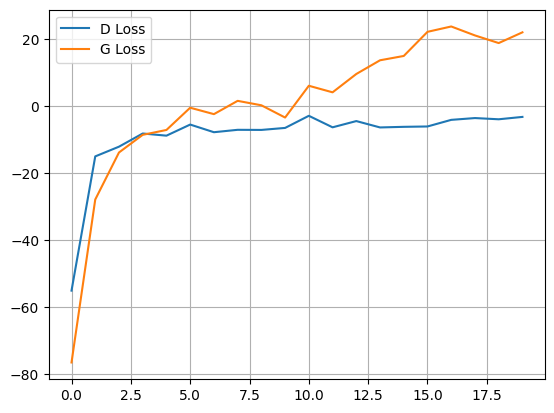

In [54]:
plt.plot(loss_D_hist, label = 'D Loss')
plt.plot(loss_G_hist, label = 'G Loss')
plt.grid(True)
plt.legend()